In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import median
import gzip
import scipy.io
import scanpy as sc

In [5]:
DATA = Path('/content/drive/My Drive/gbm')

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.3 leidenalg==0.8.2


# Part 1. Load and filter data

In [6]:
filename = DATA/"GSE89567_IDH_A_processed_data.txt.gz"
raw = pd.read_csv(filename, compression='gzip', sep='\t', index_col=0)
raw

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,MGH42_P7_B03,MGH42_P7_B05,MGH42_P7_B06,MGH42_P7_B07,MGH42_P7_B08,MGH42_P7_B09,MGH42_P7_B12,MGH42_P7_C01,MGH42_P7_C02,MGH42_P7_C03,MGH42_P7_C05,MGH42_P7_C06,MGH42_P7_C07,MGH42_P7_C08,MGH42_P7_C09,MGH42_P7_C11,MGH42_P7_C12,MGH42_P7_D03,MGH42_P7_D04,MGH42_P7_D05,MGH42_P7_D06,MGH42_P7_D07,MGH42_P7_D10,MGH42_P7_D11,MGH42_P7_D12,MGH42_P7_E01,MGH42_P7_E02,MGH42_P7_E04,MGH42_P7_E05,MGH42_P7_E06,...,MGH107neg_P1_B12,MGH107neg_P2_G04,MGH107neg_P1_G04,MGH107neg_P5_C09,MGH107neg_P1_D05,MGH107neg_P1_A05,MGH107neg_P1_G11,MGH107pos_P2_F02,MGH107pos_P2_E06,MGH107pos_P2_C02,MGH107neg_P1_E11,MGH107neg_P5_C03,MGH107pos_P2_D06,MGH107pos_P2_C05,MGH107pos_P2_G07,MGH107neg_P5_E10,MGH107neg_P2_F02,MGH107neg_P1_E10,MGH107neg_P1_C02,MGH107neg_P2_A12,MGH107pos_P2_B06,MGH107neg_P5_A08,MGH107pos_P2_D12,MGH107pos_P2_B10,MGH107neg_P1_A10,MGH107neg_P5_H02,MGH107pos_P2_B09,MGH107neg_P1_C08,MGH107pos_P2_A03,MGH107pos_P2_G11,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
'A1BG',1.19280,0.000000,0.00000,0.00000,0.00000,0.66903,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,1.87810,1.47770,0.00000,1.481800,0.57725,0.00000,2.76400,0.00000,2.78510,0.00000,0.00000,0.00000,0.00000,2.93190,0.00000,0.00000,0.0000,0.00000,1.30630,0.00000,0.00000,0.0000,0.00000,0.000000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.76638,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,1.32190,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.4772,0.00000,0.0000
'A1BG-AS1',0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.26664,0.00000,1.23940,0.00000,0.00000,0.00000,0.00000,0.00000,1.16860,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.000000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.15316,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.83996,0.00000,0.0000,0.00000,0.0000
'A1CF',0.00000,0.094912,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.15575,0.0000,0.00000,0.048236,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.079975,0.00000,0.0,0.00000,0.00000,0.00000,0.085425,0.00000,0.00000,0.00000,0.00000,0.077243,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000
'A2M',7.04390,7.609500,0.77062,7.61460,0.00000,0.00000,0.27501,8.16240,6.56550,6.96580,0.542010,8.65190,0.12697,0.389570,0.00000,6.89800,0.00000,7.887400,7.70440,7.77910,0.28214,7.14620,0.00000,0.45312,0.00000,6.78530,0.43189,8.11460,0.23143,0.23879,6.0937,7.54340,6.99230,7.11250,1.26720,0.0000,0.48954,7.334100,6.52820,6.823900,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,6.33120,8.6133,8.56790,0.0000,0.00000,8.9363,0.2228,8.18260,0.00000,0.489540,0.00000,0.0,0.00000,7.99150,0.00000,8.518700,5.96860,0.00000,0.36401,7.23530,0.631340,8.75160,7.68400,0.00000,8.60460,0.00000,0.00000,0.00000,0.00000,9.52810,0.0000,6.89990,0.0000
'A2M-AS1',0.00000,0.000000,0.00000,0.00000,2.03390,2.39420,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.24975,0.00000,0.374070,0.00000,0.00000,0.00000,0.00000,0.0000

## Library size

In [7]:
ls = np.sum(raw, axis=0)  # library size
ls.shape

(6341,)

Text(6.205555555555547, 0.5, 'Frequency')

<Figure size 640x640 with 0 Axes>

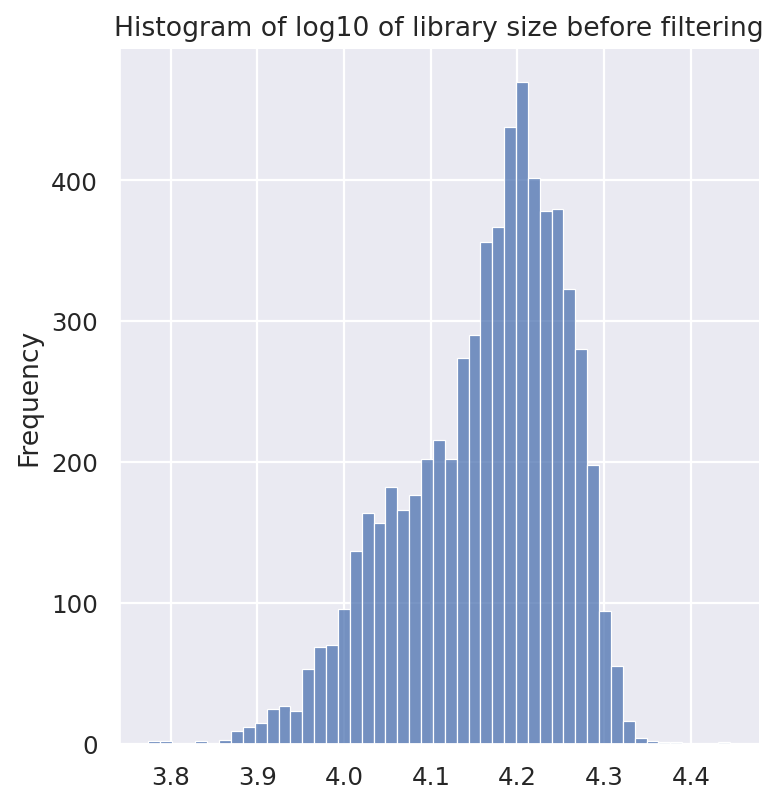

In [8]:
sc.settings.set_figure_params(dpi=80)
sns.set(color_codes=True)

plt.figure(figsize=(8, 8))
sns.displot(np.log10(ls))
plt.title('Histogram of log10 of library size before filtering')
plt.ylabel('Frequency')

## Number of cells per gene

In [9]:
num_cells = np.sum(raw>0, axis=1)

# Add 1 to those genes that are expressed in 0 cells for log calculation
num_cells[num_cells==0] = 1  
num_cells.shape

(23686,)

Text(-1.6694444444444532, 0.5, 'Density')

<Figure size 640x640 with 0 Axes>

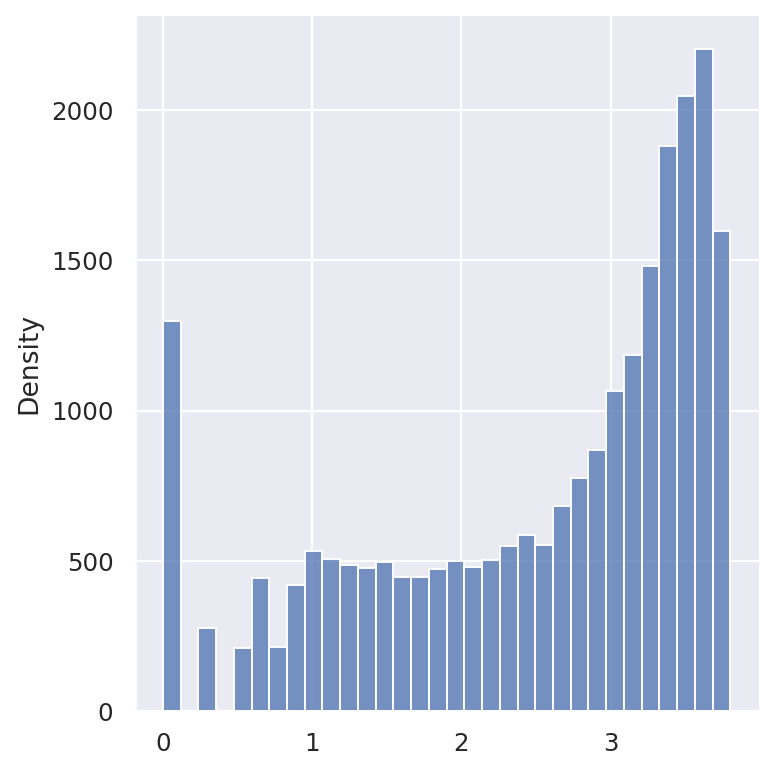

In [10]:
plt.figure(figsize=(8, 8))
sns.displot(np.log10(num_cells))
plt.ylabel('Density')

# Part 2. Batch correction and normalization

In [36]:
# Convert to AnnData
adata = sc.AnnData(raw.transpose())

# Add 'batch' column to Anndata.obs
adata.obs['batch'] = raw.columns.str[0:6].astype('category')

adata

AnnData object with n_obs × n_vars = 6341 × 23686
    obs: 'batch'

In [37]:
# np.sum(np.isnan(adata.X))

In [38]:
adata.obs

,batch
MGH42_P7_A01,MGH42_
MGH42_P7_A02,MGH42_
MGH42_P7_A03,MGH42_
MGH42_P7_A04,MGH42_
MGH42_P7_A05,MGH42_
...,...
MGH107neg_P2_C05,MGH107
MGH107pos_P2_D07,MGH107
MGH107neg_P1_E01,MGH107
MGH107pos_P2_G09,MGH107


In [1]:
sc.pp.combat(adata, key='batch')
adata

In [2]:
threshold_cells = 3.5
threshold_genes = 2
sc.pp.filter_cells(adata, min_genes=10**threshold_cells)
sc.pp.filter_genes(adata, min_cells=10**threshold_genes)

In [41]:
adata

AnnData object with n_obs × n_vars = 6341 × 22695
    obs: 'batch', 'n_genes'
    var: 'n_cells'

In [42]:
# Normalization
sc.pp.normalize_total(adata)

normalizing counts per cell
    finished (0:00:00)


In [43]:
# Double check the normalization result - each cell should have total counts = median_ls
adata.X.sum(axis=1)

array([15132.51169758, 15132.51169758, 15132.51169758, ...,
       15132.51169758, 15132.51169758, 15132.51169758])

In [44]:
adata_out = adata.copy()
adata_out

AnnData object with n_obs × n_vars = 6341 × 22695
    obs: 'batch', 'n_genes'
    var: 'n_cells'

In [58]:
adata_out.X.sum(axis=1)

array([15132.51169758, 15132.51169758, 15132.51169758, ...,
       15132.51169758, 15132.51169758, 15132.51169758])

# Part 3. Dimensionality reduction

In [45]:
sc.settings.set_figure_params(dpi=100)

# sc.pp.log1p(adata)
# # remove highly variable genes
# sc.pp.scale(adata, max_value=10)
# Use PCA and decide the number of principle components in Umap
sc.tl.pca(adata, n_comps=100, svd_solver='auto')

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=100
    finished (0:00:23)


In [3]:
sc.pl.pca_variance_ratio(adata, n_pcs=100, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


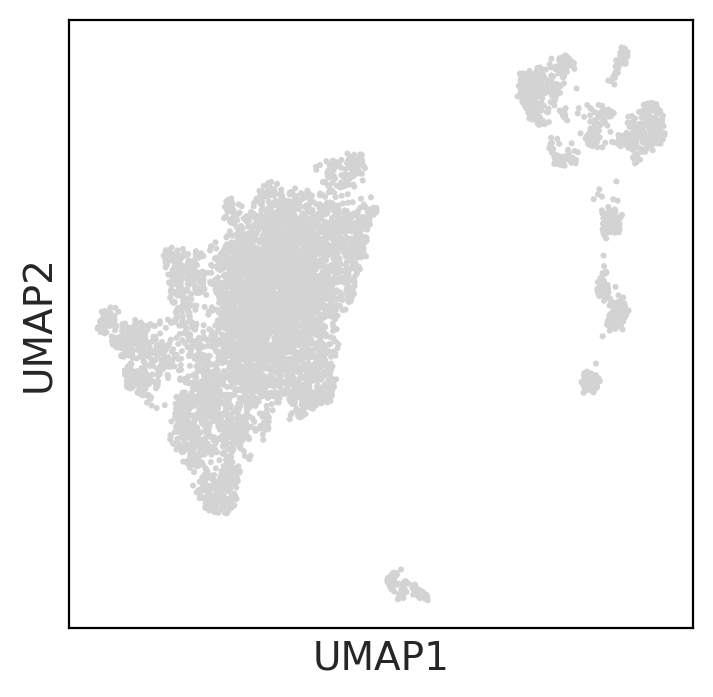

In [47]:
# Based on the figures above, choose the number of principle components
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# Part 4. Cluster cells based on marker genes

In [48]:
sc.tl.leiden(adata, resolution=0.1)
adata.obs

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


,batch,n_genes,leiden
MGH42_P7_A01,MGH42_,14383,1
MGH42_P7_A02,MGH42_,13770,1
MGH42_P7_A03,MGH42_,14903,0
MGH42_P7_A04,MGH42_,14319,1
MGH42_P7_A05,MGH42_,14302,0
...,...,...,...
MGH107neg_P2_C05,MGH107,19143,0
MGH107pos_P2_D07,MGH107,19112,1
MGH107neg_P1_E01,MGH107,18752,0
MGH107pos_P2_G09,MGH107,19185,1


In [49]:
adata.obs.leiden

MGH42_P7_A01        1
MGH42_P7_A02        1
MGH42_P7_A03        0
MGH42_P7_A04        1
MGH42_P7_A05        0
                   ..
MGH107neg_P2_C05    0
MGH107pos_P2_D07    1
MGH107neg_P1_E01    0
MGH107pos_P2_G09    1
MGH107neg_P1_D06    0
Name: leiden, Length: 6341, dtype: category
Categories (4, object): ['0', '1', '2', '3']

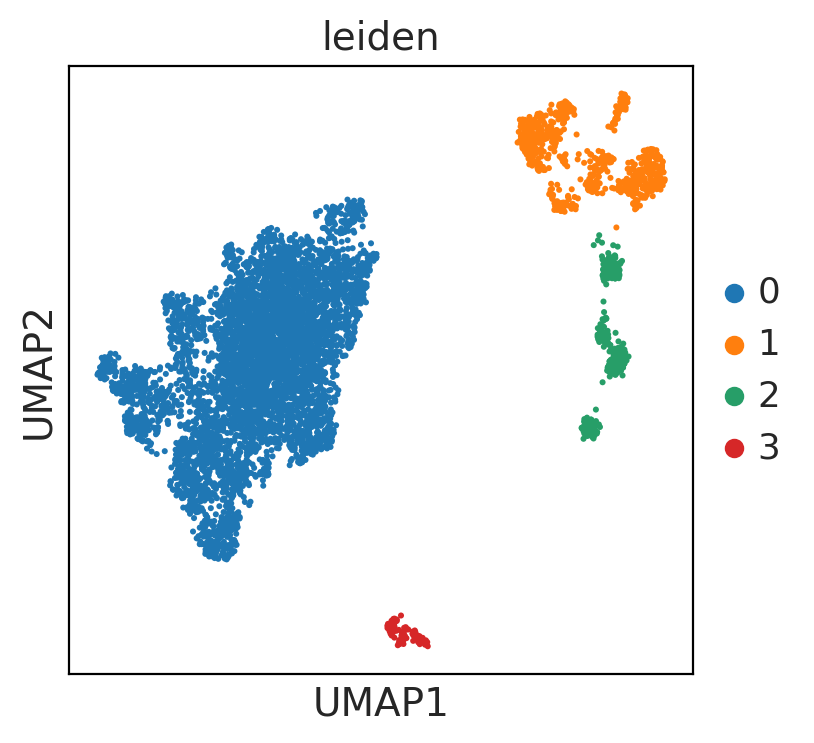

In [50]:
sc.pl.umap(adata, color='leiden')

In [4]:
# # Decide what marker genes to be marked for each cluster
# sc.settings.set_figure_params(dpi=150)
# marker_genes = [
#                 "'IDH1'",
#                 "'EGFR'",
#                 "'NOVA1'",  # tumor cell markers
#                 "'UCHL1'",
#                 "'CD14'",   # macrophage markers
#                 "'CD68'",
#                 "'CD74'",
#                 "'VWF'",    # endothelial markers
#                 # "'CLDN5'"
#                 ]

# sc.pl.dotplot(adata, marker_genes, groupby='leiden')

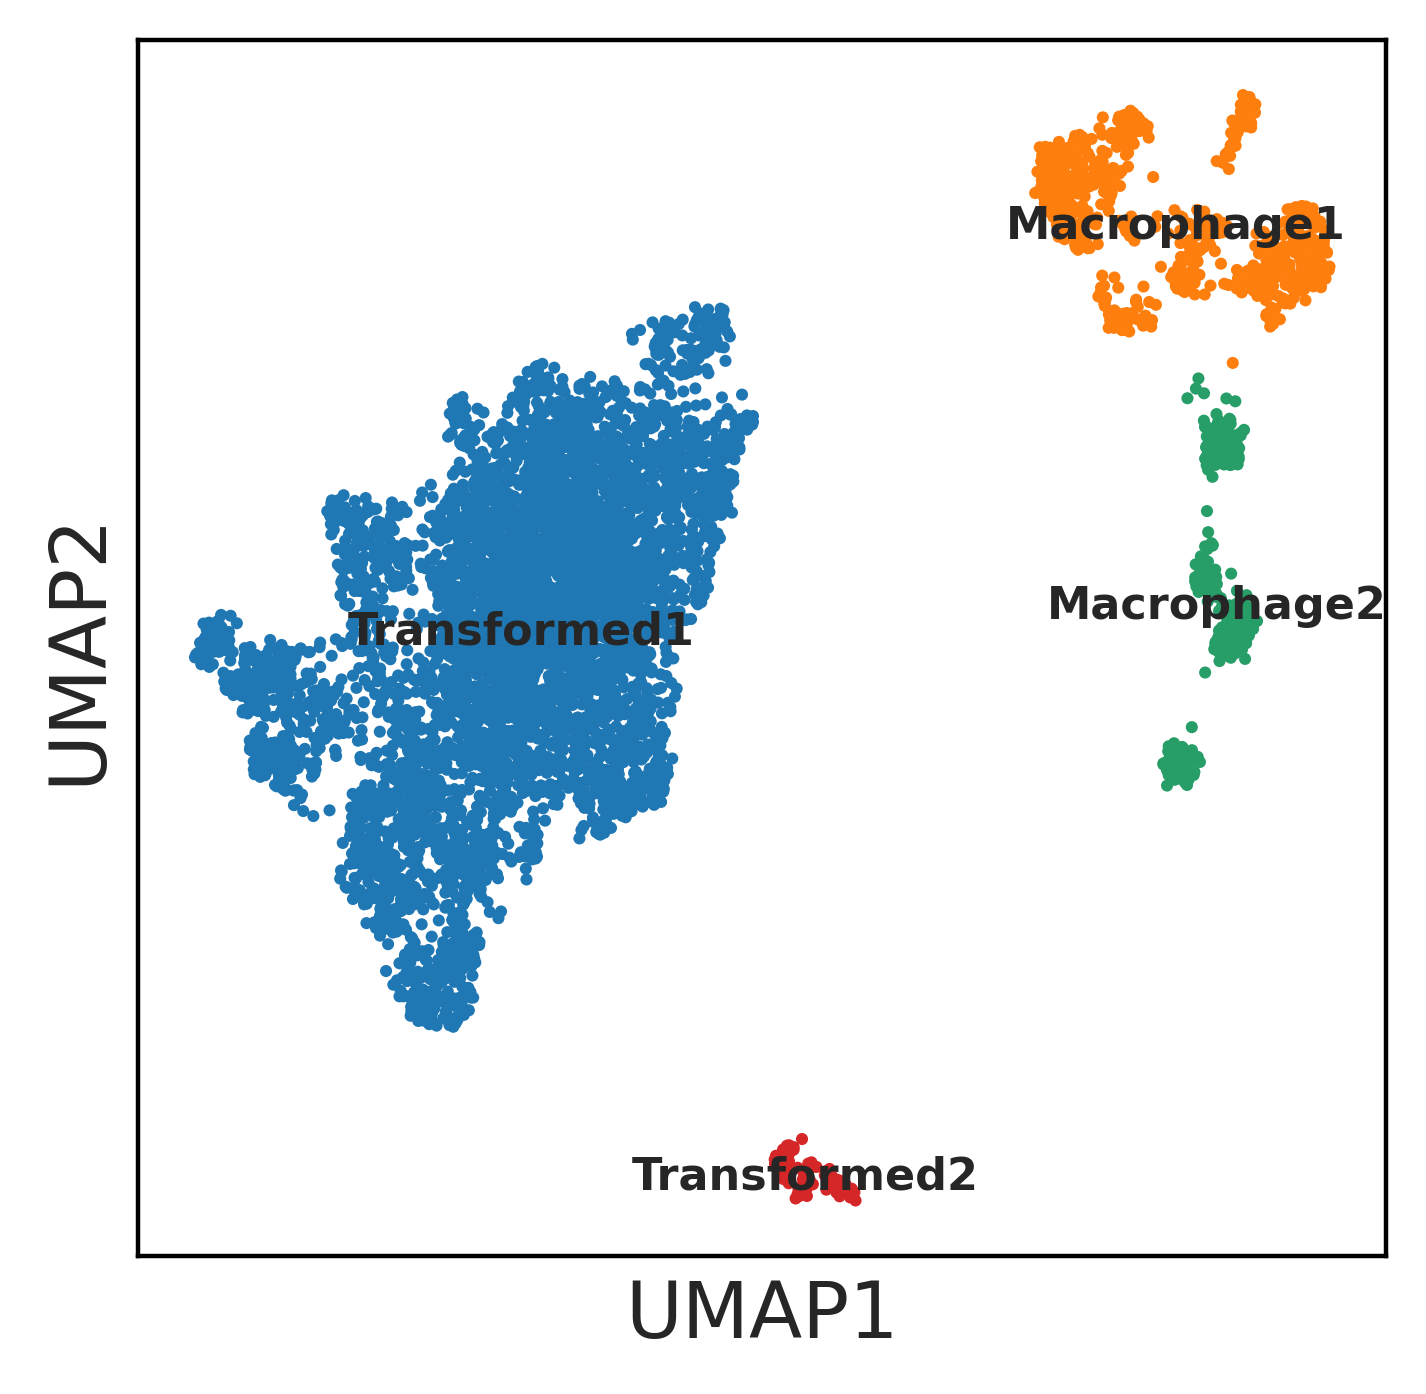

In [52]:
cluster_names = [
                 'Transformed1', #0
                 'Macrophage1', #2
                 'Macrophage2', #3
                 'Transformed2' #4
                ]
adata.rename_categories('leiden', cluster_names)

sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color='leiden', legend_loc='on data', 
           title='', legend_fontsize=8)

In [53]:
adata.obs.groupby('leiden').count()

,batch,n_genes
leiden,,
Transformed1,5231,5231
Macrophage1,701,701
Macrophage2,308,308
Transformed2,101,101


In [54]:
adata.obs

,batch,n_genes,leiden
MGH42_P7_A01,MGH42_,14383,Macrophage1
MGH42_P7_A02,MGH42_,13770,Macrophage1
MGH42_P7_A03,MGH42_,14903,Transformed1
MGH42_P7_A04,MGH42_,14319,Macrophage1
MGH42_P7_A05,MGH42_,14302,Transformed1
...,...,...,...
MGH107neg_P2_C05,MGH107,19143,Transformed1
MGH107pos_P2_D07,MGH107,19112,Macrophage1
MGH107neg_P1_E01,MGH107,18752,Transformed1
MGH107pos_P2_G09,MGH107,19185,Macrophage1


In [59]:
# adata.obs.to_csv(DATA/"GSE89567_annotation_in_leiden.csv")

In [56]:
mtx = pd.DataFrame(adata_out.X.transpose(), 
                              index=adata_out.var.index, 
                              columns=adata_out.obs.index)
mtx

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,MGH42_P7_B03,MGH42_P7_B05,MGH42_P7_B06,MGH42_P7_B07,MGH42_P7_B08,MGH42_P7_B09,MGH42_P7_B12,MGH42_P7_C01,MGH42_P7_C02,MGH42_P7_C03,MGH42_P7_C05,MGH42_P7_C06,MGH42_P7_C07,MGH42_P7_C08,MGH42_P7_C09,MGH42_P7_C11,MGH42_P7_C12,MGH42_P7_D03,MGH42_P7_D04,MGH42_P7_D05,MGH42_P7_D06,MGH42_P7_D07,MGH42_P7_D10,MGH42_P7_D11,MGH42_P7_D12,MGH42_P7_E01,MGH42_P7_E02,MGH42_P7_E04,MGH42_P7_E05,MGH42_P7_E06,...,MGH107neg_P1_B12,MGH107neg_P2_G04,MGH107neg_P1_G04,MGH107neg_P5_C09,MGH107neg_P1_D05,MGH107neg_P1_A05,MGH107neg_P1_G11,MGH107pos_P2_F02,MGH107pos_P2_E06,MGH107pos_P2_C02,MGH107neg_P1_E11,MGH107neg_P5_C03,MGH107pos_P2_D06,MGH107pos_P2_C05,MGH107pos_P2_G07,MGH107neg_P5_E10,MGH107neg_P2_F02,MGH107neg_P1_E10,MGH107neg_P1_C02,MGH107neg_P2_A12,MGH107pos_P2_B06,MGH107neg_P5_A08,MGH107pos_P2_D12,MGH107pos_P2_B10,MGH107neg_P1_A10,MGH107neg_P5_H02,MGH107pos_P2_B09,MGH107neg_P1_C08,MGH107pos_P2_A03,MGH107pos_P2_G11,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
'A1BG',1.187306,-0.026585,-0.016561,-0.023655,-0.017968,0.440905,-0.019386,-0.025668,-0.029796,-0.027891,-0.018207,-0.026420,-0.016793,-0.017053,1.211169,1.550453,-0.016914,1.553674,0.572859,-0.026242,1.988155,-0.023584,2.120245,-0.038285,-0.019145,-0.048234,-0.018106,5.157933,-0.017580,-0.017221,-0.031998,-0.027835,1.322434,-0.031876,-0.017535,-0.019784,-0.018825,-0.025698,-0.030318,-0.026153,...,0.036685,0.038688,0.038034,0.039240,0.028383,0.034899,0.035132,0.050792,0.049048,0.045655,0.036522,0.620070,0.053547,0.053893,0.057484,0.038927,0.033158,0.037761,0.033529,0.041515,0.041824,0.039560,0.045659,0.056576,0.033074,0.036030,0.044401,0.026863,0.048248,1.656772,0.034473,0.045309,0.034028,0.035759,0.040779,0.033050,0.051670,2.074615,0.052273,0.036441
'A1BG-AS1',0.012710,0.013485,0.008401,0.011999,0.009114,0.008556,0.009833,0.013020,0.015114,0.014147,0.009236,0.013401,0.008518,0.008650,0.008172,0.013343,0.008580,0.013333,0.324928,0.013311,1.024285,0.011963,0.009605,0.019420,0.009711,0.024466,0.977854,0.022186,0.008918,0.008735,0.016231,0.014119,0.012903,0.016169,0.008895,0.010035,0.009549,0.013035,0.015379,0.013266,...,0.051352,0.054156,0.053241,0.054929,0.039732,0.048852,0.049178,0.071100,0.068659,0.063909,0.051125,0.044180,0.074956,0.075441,0.080467,0.054490,0.046416,0.052858,0.046935,0.058113,0.058547,0.055377,0.063915,0.079196,0.046298,0.050436,0.248713,0.037603,0.067539,0.069933,0.048256,0.063424,0.047633,0.050056,0.057084,0.807847,0.072329,0.047396,0.073173,0.051011
'A1CF',-0.004258,0.103494,-0.002814,-0.004019,-0.003053,-0.002866,-0.003294,-0.004361,-0.005063,-0.004739,-0.003094,-0.004489,-0.002853,-0.002898,-0.002737,-0.004470,-0.002874,-0.004466,-0.004342,-0.004459,-0.003040,-0.004007,-0.003217,-0.006505,-0.003253,-0.008196,-0.003077,-0.007432,-0.002987,-0.002926,-0.005437,-0.004730,-0.004322,-0.005416,0.113930,-0.003362,-0.003199,0.048695,-0.005151,-0.004444,...,0.002744,0.002894,0.002845,0.002936,0.002123,0.002611,0.002628,0.003800,0.003669,0.003416,0.002732,0.002361,0.004006,0.004032,0.004300,0.002912,0.043964,0.002825,0.002508,0.003106,0.003129,0.002960,0.064431,0.004233,0.002474,0.002696,0.003322,0.034468,0.003610,0.003738,0.002579,0.003390,0.002546,0.002675,0.003051,0.002473,0.003866,0.002533,0.003911,0.002726
'A2M',6.049037,6.974504,0.153306,6.210234,-0.346092,-0.324905,-0.176107,7.259118,6.665734,6.652558,0.014505,7.950326,-0.244553,-0.082615,-0.310297,6.208357,-0.325793,7.166191,6.794322,7.049065,-0.157816,5.782716,-0.364720,-0.095441,-0.368773,11.182662,-0.059363,12.291849,-0.188057,-0.179518,6.599538,7.234247,6.092253,7.776145,0.484567,-0.381074,-0.021557,6.479791,6.740563,6.100780,...,-0.041348,-0.043605,-0.042869,-0.044228,-0.031991,-0.039335,-0.039598,6.763760,8.905767,8.245686,-0.041165,-0.035573,10.089395,0.193945,9.91220

In [62]:
# mtx.to_csv(DATA/"GSE89567_normalized_batchcorrected.csv.gz", compression='gzip')